# Quick Start Tutorial

This tutorial will get you up and running a very simple molecular dynamics simulation. The examples here are run within a jupyter ipython notebook. You can download this notebook and run it yourself. Try modifying the code (i.e. change the number of particles or the temperature) and see what happens when you rerun it.

## Example Script

Let's start with the classic MD simulation, the Lennard-Jones system. Place N particles on a lattice and allow them to interact with the following potential between pairs of particles:

$ V(r) = 4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right] $

Configure HOOMD to perform this simulation with a python script.

In [3]:
# import hoomd and the md package
import hoomd
from hoomd import md

# initialize the execution context
hoomd.context.initialize('--mode=cpu')

# create a simple cubic lattice of 125 particles
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=2.0), n=5)

# specify Lennard-Jones interactions between particle pairs
nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=3.0, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)

# integrate with brownian dynamics
all_atoms = hoomd.group.all();
hoomd.md.integrate.mode_standard(dt=0.001)
hoomd.md.integrate.brownian(group=all_atoms, kT=0.1, seed=987)

# run 200,000 time steps
hoomd.run(2e5)

notice(2): Group "all" created containing 125 particles
notice(2): integrate.langevin/bd is using specified gamma values
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 125
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 125556 / 200000 | TPS 12555.6 | ETA 00:00:05
Time 00:00:16 | Step 200000 / 200000 | TPS 12211.5 | ETA 00:00:00
Average TPS: 12425
---------
-- Neighborlist stats:
5188 normal updates / 2001 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 56 / n_neigh_avg: 24.584
shortest rebuild period: 11
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 0 / n_max: 47 / n_avg: 15.625
** run complete **


---

## Understanding the output

The first few lines of output are just a header notifying you which version of HOOMD-blue you are running and when it was compiled along with a link to the website and the reference to the paper discussing the algorithms used in HOOMD-blue.
```
HOOMD-blue v2.0.1 DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 07/28/2016
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
```

HOOMD also prints information on the execution configuration. Here, the notebook is running on the CPU.
```
HOOMD-blue is running on the CPU
```

Next in the simulation output we have:
```
notice(2): Group "all" created containing 125 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 125
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
```
This prints relevant particle information, such as how many particles are in the simulation.

When a run() command is executed, hoomd steps the simulation forward that many time steps. While it is doing so, it periodically prints out status lines like the one seen below.
```
** starting run **
Time 00:00:10 | Step 85829 / 200000 | TPS 8582.82 | ETA 00:00:13
Time 00:00:20 | Step 171887 / 200000 | TPS 8605.74 | ETA 00:00:03
Time 00:00:23 | Step 200000 / 200000 | TPS 8415.16 | ETA 00:00:00
Average TPS: 8568.51
---------
```
- __Time__ is the total time spent (so far) in the current simulation in HH:MM:SS (over multiple run() commands)
- __Step__ current / final prints the current time step the simulation is at and the final time step of the run()
- __TPS__ is the current rate (in time steps per second) at which the simulation is progressing.
- __ETA__ is the estimated time to completion of the current run() in HH:MM:SS

The final bit of output at the end of the run prints statistics from various parts of the computation.
```
---------
-- Neighborlist stats:
5188 normal updates / 2000 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 56 / n_neigh_avg: 24.584
shortest rebuild period: 11
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 0 / n_max: 47 / n_avg: 15.625
** run complete **
```
In this example, only the neighbor list prints statistics.

---
## Line by line details

1. Before you can use hoomd in your script, you need to import it and any packages you will use later.
```
from hoomd import *
from hoomd import md
```
This line imports everything in the ``hoomd`` module, such as ``init``, which we use for the command  ``init.create_lattice``. The [documentation for all the submodules](http://hoomd-blue.readthedocs.io/en/stable/package-hoomd.html) lists all the commands that are available.

2. The next line initializes the execution context. The context must be initialized before any other command can be executed. Here, the execution context is set to run on the CPU.
```
context.initialize('--mode=cpu')
```

3. After the context is initialized, the system must be initialized. In this example, we create a simple cubic lattice with a unit spacing of ```a=2.0```, repeated 5 times in every direction.
```
system = init.create_lattice(unitcell=lattice.sc(a=2.0), n=5)
```

4. The next line specifies the pair force between particle pairs in the simulation. In the example, we create a Lennard-Jones pair force with a cutoff radius of 3.0 using the cell neighbor list. This line has the structure `<variable>=<command>` which saves the result of the command for later modification (see why on the next line of the script). Here is [documentation for pair.lj](http://hoomd-blue.readthedocs.io/en/stable/module-md-pair.html#hoomd.md.pair.lj).
```
nl = md.nlist.cell()
lj = md.pair.lj(r_cut=3.0, nlist=nl)
```

5. The next line sets the parameters epsilon and sigma for the Lennard-Jones force between particles of types `'A'` and `'A'`. HOOMD particle are named by arbitraray strings of any length; `'My ridiculously long particle type name'` is a valid particle type name. The particle type name is `'A'` here because ``lattice.sc`` defaults to `'A'` unless you override it. See the [documentation for lattice.sc](http://hoomd-blue.readthedocs.io/en/stable/module-hoomd-lattice.html#hoomd.lattice.sc) for information on how to change it.
```
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
```

6. Next, the script specifies a standard integration mode with a time step dt set to 0.001. Brownian dynamics is applied to all particles, with the the target kT set at 0.1, and the random number generator seed set to 987. Like with the pair force above, the group is saved in a variable to be used a few lines later in the script.  For additional details, see the documentation for [group](http://hoomd-blue.readthedocs.io/en/stable/module-hoomd-group.html), 
[integrate](http://hoomd-blue.readthedocs.io/en/stable/module-md-integrate.html), and [integrate.brownian](http://hoomd-blue.readthedocs.io/en/stable/module-md-integrate.html#hoomd.md.integrate.brownian).
```
all = group.all();
md.integrate.mode_standard(dt=0.001)
md.integrate.brownian(group=all, kT=0.1, seed=987)
```

7. Finally, the run command takes the settings previously specified and runs the simulation through time. [Documentation for run](http://hoomd-blue.readthedocs.io/en/stable/package-hoomd.html#hoomd.run).
```
hoomd.run(2e5)
```

---
## Components of a hoomd command

```
md.integrate.brownian(group=all, kT=0.1, seed=987)
```
Parts of the command line:
- __md__ The molecular dynamics package.
- __.__ Python syntax needed to access a member of the package.
- __integrate__ The integrate submodule. Every command is in its own package and module to keep it organized.
- __brownian__ The command name to run.
- __(__ Python required syntax to note the start of an argument list
- __group=all, kT=0.1, seed=987__ Arguments (more on these below).
- __)__ Python required syntax to note the end of an argument list.

About the arguments:
Multiple keyword arguments of the form `name=value` are separated by commas. Whitespace is ignored so `name = value` works too. The order of keyword arguments doesn't matter (as long as you specify them using their keyword `name`), i.e. all of the following produce identical results:
```
md.integrate.brownian( group = all, kT = 0.1, seed = 987 )
md.integrate.brownian(seed=987,group=all,kT=0.1)
md.integrate.brownian(kT=0.1, group=all, seed=987)
```
Check the documentation for a specific command to see what arguments exist and what they control (i.e. see [md.integrate.brownian](http://hoomd-blue.readthedocs.io/en/stable/module-md-integrate.html#hoomd.md.integrate.brownian)).
Here is a copy of a portion of the documentation for ``md.integrate.brownian``.


> _class_ __hoomd.md.integrate.brownian(group, kT, seed, dscale=False, noiseless_t=False, noiseless_r=False)__
>
> Brownian dynamics.
>
> __Parameters:__
> - __group__ (hoomd.group) – Group of particles to apply this method to.
> - __kT__ (hoomd.variant or float) – Temperature of the simulation (in energy units).
> - __seed_ (int) – Random seed to use for generating random forces.
> - __dscale__ (bool) – Control lambda options. If 0 or False, use gama values set per type. If non-zero, gamma=lambda*d_i.
> - __noiseless_t__ (bool) – If set true, there will be no translational noise (random force)
> - __noiseless_r__ (bool) – If set true, there will be no rotational noise (random torque)

In the header for the command, notice that some arguments are listed with an equal sign (`=`), like __dscale=False__. This means that keyword argument has a default value associated with it. If you do not specify that argument, it will assume the default value.

Those arguments that are listed without the equal sign (group, kT, seed) have no default value and must be specified. Python will give you an error if you do not.

---
## Data visualization

Now let's look at the output visually. We can do this using the __take_snapshot()__ command, which stores the current configuration of the simulation. We can then use the pyplot module to plot the 3D positions of the particles in a 3D scatter plot.

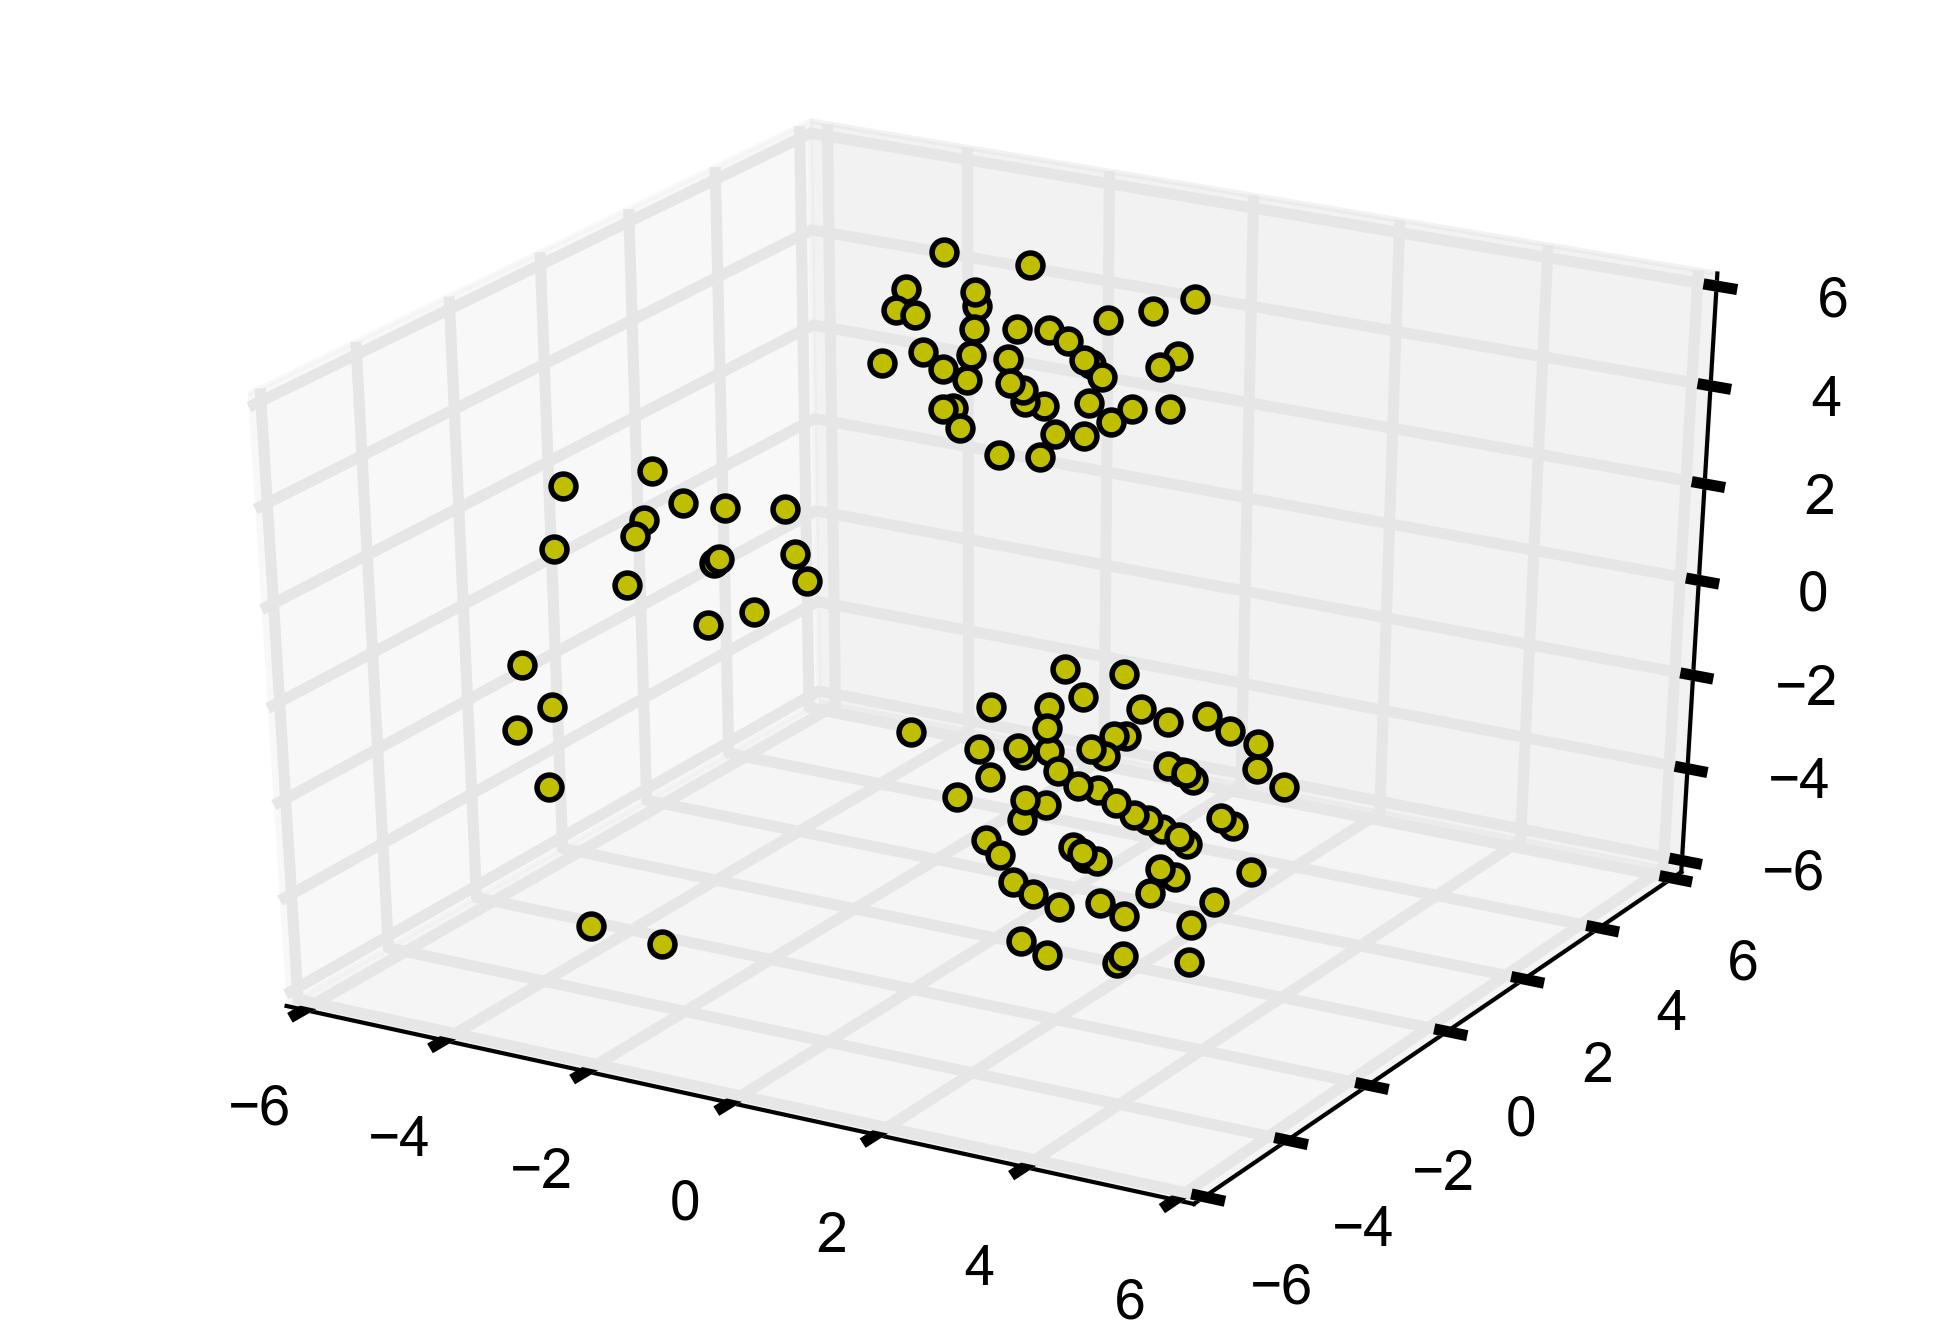

In [6]:
# take a snapshot of the current state of the system and save the particle positions
snapshot = system.take_snapshot(all=True)
pos = snapshot.particles.position

# a visual representation using matplotlib
# %matplotlib inline
# import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for part in pos:
    ax.scatter(part[0], part[1], part[2], c='y')
plt.show()

The __```%matplotlib inline```__ line forces the output to be visualized within the jupyter notebook. Remove this line to render in its own window and allow for fully 3D rotatable output.